# MobileNets

In this notebook, we will study one of the most influential Deep learning architecture called MobileNets. MobileNets was invented to run deep learning inference models on compute constrained environments such as Mobile phones, hence its name. In contrast to the conventional CNN architecture, it exploits the separability property of the <b>convolutional kernels or filters</b> and introducing two global hyperparameters namely, <b>width multiplier and resolution multiplier</b> to make it compute efficient.  

The image below shows the difference between a conventional convolution operation and depthwise separable convolution. 

<div style="width:100%;text-align: center;">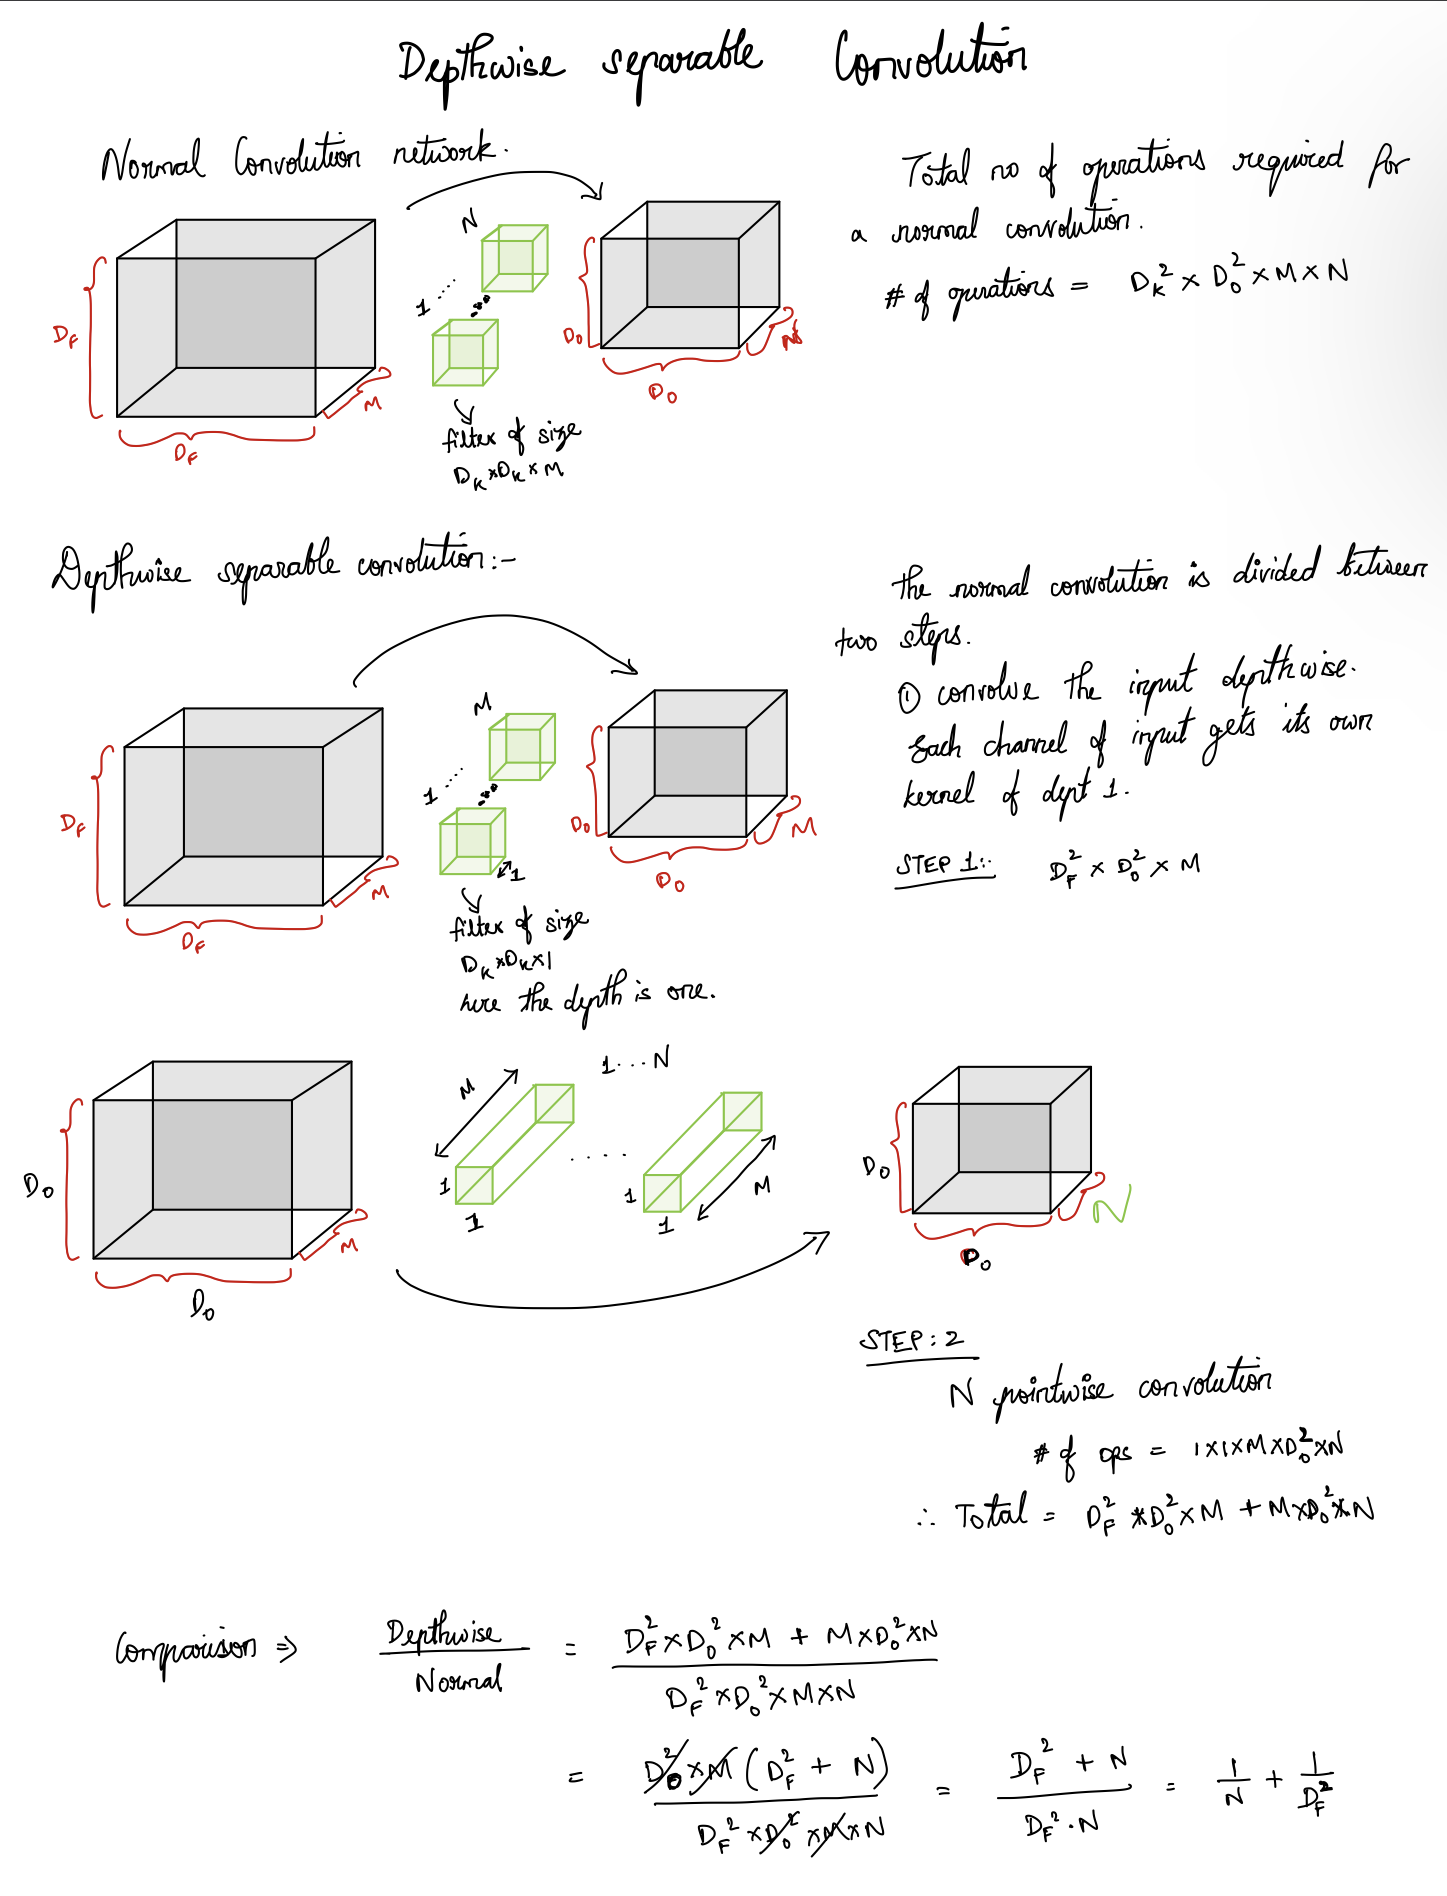</div>
For more information take a look at the original paper in which MobileNets was introduced. <a href="https://arxiv.org/pdf/1704.04861">MobileNets </a>

### Image correction
### explain a little bit about the math and the significance

In [2]:
# import all the required lib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid

!pip install torchinfo
from torchinfo import summary 

import numpy as np
import matplotlib.pyplot as plt

import random
import time
import copy
import os

# lucy seed why this seed no

In [3]:
# set seed for random number generation
SEED_NO = 3407
random.seed(SEED_NO)
np.random.seed(SEED_NO)
g = torch.Generator()
g.manual_seed(SEED_NO)
torch.cuda.manual_seed(SEED_NO)
torch.backends.cudnn.deterministic = True

# Prepare data

Now we will download the train dataset, normalize it and define proper transforms for the data. Since we are training the model from scratch, CIFAR10 dataset would be of sufficient challenge for the model to learn. The transforms contain the following steps,
- Find the mean and standard deviation of the downloaded data.
- To increase the amount of data we have, we will follow data augmentation technique. For more information about data augmentation read this [link](https://pytorch.org/vision/stable/transforms.html).
    
    

In [4]:
trainval_data = datasets.CIFAR10(root='.', train=True, download=True)
test_data = datasets.CIFAR10(root='.', train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [5]:
# plot images

Calculate the mean and standard deviation of the trainval dataset, use this to normalize the training dataset. Once the standard deviation and mean are calculated, we can define transform chain for both train data and test data. The transform chain consists of randomfilp, randomcrop, random rotation. For more such techniques checkout `torchvision.transforms`.

In [6]:
data = torch.tensor(trainval_data.data).to(torch.float32)/255
data_new = data.reshape(-1, 3)
mean = torch.mean(data_new, dim=0)
std = torch.std(data_new, dim=0)

print(f'Calculated mean = {mean}')
print(f'Calculated standard deviation = {std}')

Calculated mean = tensor([0.4914, 0.4822, 0.4465])
Calculated standard deviation = tensor([0.2470, 0.2435, 0.2616])


In [7]:
# define transforms
train_dataset_transforms = transforms.Compose(
                            [transforms.RandomHorizontalFlip(0.5), 
                             transforms.RandomRotation(5), 
                             transforms.RandomCrop(32, padding=5),
                             transforms.ToTensor(), 
                             transforms.Normalize(mean=mean, std=std)])
test_dataset_transforms = transforms.Compose(
                            [transforms.RandomCrop(32), 
                             transforms.ToTensor(),
                             transforms.Normalize(mean=mean, std=std)])

In [8]:
# load the data with the transforms
trainval_final = datasets.CIFAR10(root='.', train=True, transform=train_dataset_transforms)
test_final = datasets.CIFAR10(root='.', train=False, transform=test_dataset_transforms)

In [9]:
# split the data into training and validation set
train_data_ratio = 0.9
train_size = int(len(trainval_final) * train_data_ratio)
validation_size = len(trainval_final) - train_size
train_final, valid_final = random_split(trainval_final, lengths=[train_size, validation_size], generator=g)
valid_final.dataset.transform = test_dataset_transforms

print(f'Final training dataset size = {len(train_final)}')
print(f'Final validation dataset size = {len(valid_final)}')
print(f'Final test dataset size = {len(test_final)}')
# store the different dataset sizes for later use
dataset_sizes = {'train': len(train_final), 'val': len(valid_final), 'test': len(test_final)}

Final training dataset size = 45000
Final validation dataset size = 5000
Final test dataset size = 10000


In [10]:
# define dataloader 
train_dataloader = DataLoader(train_final, batch_size=32, shuffle=True, generator=g)
validation_dataloader = DataLoader(valid_final, batch_size=32, generator=g)
test_dataloader = DataLoader(test_final, batch_size=32, generator=g)

dataloader = dict()
dataloader['train'] = train_dataloader
dataloader['val'] = validation_dataloader
dataloader['test'] = test_dataloader

### Single block of conventional and depthwise separable block comparison
<div style="width:50%;text-align: center;">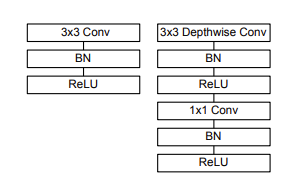</div>

### Calculation of final paremeter ratio
<div style="width:60%; text-align: center;">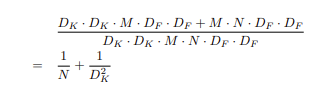</div>

Here 

In [11]:
# lets define a convolutional block as shown in the top left image
conventional_block = torch.nn.Sequential(
                        nn.Conv2d(3, 3, kernel_size=3, padding=1), 
                        nn.BatchNorm2d(3),
                        nn.ReLU())

# depthwise convolutional block for the architecture as shown in the top right image
depthwise_convolutional_block = torch.nn.Sequential(
                        nn.Conv2d(3, 3, kernel_size=3, padding=1, groups=3),
                        nn.BatchNorm2d(3),
                        nn.ReLU(),
                        nn.Conv2d(3, 3, kernel_size=1),
                        nn.BatchNorm2d(3), 
                        nn.ReLU())


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The conventional block has {count_parameters(conventional_block):,} trainable parameters')
print(f'The depthwise separable block has {count_parameters(depthwise_convolutional_block):,} trainable parameters')

The conventional block has 90 trainable parameters
The depthwise separable block has 54 trainable parameters


In [12]:
# lets take a deeper look into the blocks that we built
print('Conventional block summary with an input size of (1,3,32,32)')
conven_info = summary(conventional_block, input_size=(1,3,32,32))
conven_info

Conventional block summary with an input size of (1,3,32,32)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3, 32, 32]            --
├─Conv2d: 1-1                            [1, 3, 32, 32]            84
├─BatchNorm2d: 1-2                       [1, 3, 32, 32]            6
├─ReLU: 1-3                              [1, 3, 32, 32]            --
Total params: 90
Trainable params: 90
Non-trainable params: 0
Total mult-adds (M): 0.09
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.06

In [13]:
print("Depthwise convolutional block summary with an input size of (1,3,32,32)")
dw_info = summary(depthwise_convolutional_block, input_size=(1,3,32,32))
dw_info

Depthwise convolutional block summary with an input size of (1,3,32,32)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3, 32, 32]            --
├─Conv2d: 1-1                            [1, 3, 32, 32]            30
├─BatchNorm2d: 1-2                       [1, 3, 32, 32]            6
├─ReLU: 1-3                              [1, 3, 32, 32]            --
├─Conv2d: 1-4                            [1, 3, 32, 32]            12
├─BatchNorm2d: 1-5                       [1, 3, 32, 32]            6
├─ReLU: 1-6                              [1, 3, 32, 32]            --
Total params: 54
Trainable params: 54
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 0.00
Estimated Total Size (MB): 0.11

In [14]:
# print the no of multiplication and addition operation in both the blocks
print(f'The no of operations in the conventional block is {conven_info.total_mult_adds}')
print(f'The no of operations in the depthwise separable block is {dw_info.total_mult_adds}')
ratio = dw_info.total_mult_adds/ conven_info.total_mult_adds
print('The depthwise separable block has as many as {:0.3f} the no of operations in conventional block'.format(ratio))

The no of operations in the conventional block is 86022
The no of operations in the depthwise separable block is 43020
The depthwise separable block has as many as 0.500 the no of operations in conventional block


## Model Architecture
<div style="width:100%;text-align: center;">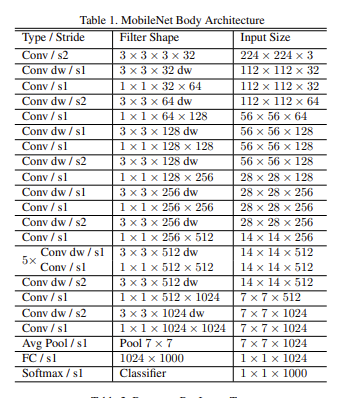</div>


Is this a complex model for the available datasize?

As depicted in the image above, the original MobileNets architecture consists of 28 layers. Each one of them is followed by a `BatchNorm layer` and `ReLU` non-linearity. The original implementation is mainly composed of three basic layers, 
- Convolutional layer with`stride 2` and `kernel size (3,3)` 
- depthwise separable convolutional layer with `stride 1` or `stride 2` and `kernel size (3,3)`
- Convolutional layer with `stride 1` and `kernel size (1,1)`.
The model is topped with an `Average Pooling` layer and a `Fully Connected` layer at the end. The feature map depth or channel size starts with 32 at the output of the first conv layer and doubles at an arbitrary layer untill it reaches 1024.

For the purpose of this notebook, we will implement a scaled down version of mobilenets. The scaled down model is adequate as the no of classes to classify is ten as opposed to thousand in the original architecture. 

In [15]:
# define the model or use pretrained network in pytorch
class MobileNetToy(nn.Module):
    
    def __init__(self, in_cha, num_classes):
        super(MobileNetToy, self).__init__()
        
        self.model = nn.Sequential(
                self.__conv_layer(in_cha, 32, 1),
                self.__efficient_block(32, 64, 1),
                self.__efficient_block(64, 64, 1), 
                self.__efficient_block(64, 128, 2), 
                self.__efficient_block(128, 128, 1),
                self.__efficient_block(128, 256, 2),
                self.__efficient_block(256, 256, 1),
                self.__efficient_block(256, 512, 2), 
                self.__efficient_block(512, 512, 1),
                self.__efficient_block(512, 512, 1),
                self.__efficient_block(512, 512, 1),
                nn.AvgPool2d(4))
        
        self.fc = nn.Linear(512, num_classes, bias=True)
    
    
    def __conv_layer(self, ip_cha, op_cha, stride):
        return nn.Sequential(
               nn.Conv2d(ip_cha, op_cha, kernel_size=3, stride=stride, padding=1, bias=False),
               nn.BatchNorm2d(op_cha),
               nn.ReLU(inplace=True))
    
    
    def __efficient_block(self, ip_cha, op_cha, stride):
        return nn.Sequential(
               # depthwise separable block
               nn.Conv2d(ip_cha, ip_cha, kernel_size=3, stride=stride, padding=1, groups=ip_cha, bias=False),
               nn.BatchNorm2d(ip_cha),
               nn.ReLU(inplace=True),
               # point operation block
               nn.Conv2d(ip_cha, op_cha, kernel_size=1, stride=1, padding=0, bias=False),
               nn.BatchNorm2d(op_cha),
               nn.ReLU(inplace=True))
    
    
    def forward(self, input):
        x = self.model(input)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x           

In [16]:
# check the model with sample input and print the summary of the model
sample_input = torch.randn(*(1,3,32,32))
mobileNet = MobileNetToy(3, 10)
output = mobileNet(sample_input)
print(f"Output size or shape : {output.shape}")

summary(mobileNet, input_size=(1, 3, 32, 32), col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"))

Output size or shape : torch.Size([1, 10])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds                 Trainable
MobileNetToy                             [1, 3, 32, 32]            [1, 10]                   --                        --                        --                        True
├─Sequential: 1-1                        [1, 3, 32, 32]            [1, 512, 1, 1]            --                        --                        --                        True
│    └─Sequential: 2-1                   [1, 3, 32, 32]            [1, 32, 32, 32]           --                        --                        --                        True
│    │    └─Conv2d: 3-1                  [1, 3, 32, 32]            [1, 32, 32, 32]           864                       [3, 3]                    884,736                   True
│    │    └─BatchNorm2d: 3-2             [1, 32, 32, 32]           [1, 32, 32, 32]           64                    

### Optimization in MobileNets
The original MobileNets model uses RMSPorp(Root Mean Squared Propagation) method for optimization. RMSProp is an extension of gradient descent that uses a decaying average of partial gradient to update the learning rate for each parameter. It overcomes the saturating tendency of learning rates in gradient descent. For more information read this [blog](https://ruder.io/optimizing-gradient-descent/index.html#rmsprop).

In [17]:
# optimizer and loss function
optimizer = optim.RMSprop(mobileNet.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# check and choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobileNet_gpu = copy.deepcopy(mobileNet)
if str(device) == 'cuda':
    mobileNet_gpu.to(device)
    criterion = criterion.to(device)
else:
    print("There is no gpu! The models will operate in cpu")

Next step is to define a training and an evalution or validation loop. This is similar to the previous notebooks.

In [18]:
# train loop and eval loop
def traintest_phase(model, optimizer, criterion, phase_list, num_epochs=50, data_iterator=None, dataset_sizes=None, save_model=False):
    since = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    if data_iterator:
        dataloader = data_iterator
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("--"*10)
        
        for phase in phase_list:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data
            for img, labels in dataloader[phase]:
                inputs = img.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients before each batch
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)
                    
                    # optimize in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # model statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f"{phase} loss : {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            # when the model performs better in the validation save the model
            if phase == 'val' and best_acc < epoch_acc and save_model:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best accuracy in validation : {best_acc:4f}")
    
    # load the best model and return it 
    if save_model:
        model.load_state_dict(best_model) 
    return model

# Training Neural Networks
1) Check inital loss - turn off weight decay check if it makes sense

2) Overfit a small sample - train to 100% accuracy of a small batch size approx (5 - 10) no regularization, fiddle with architecture, learning rate, weight initialization.
        loss not going down? LR too low, bad initialization
        loss explodes to inf or Nan? LR too high, bad initialization
        
3) find LR that makes loss go down - use the architecture from the previous step, use all training data, turn on small weight decay, find a learning rate that makes the loss drop significantly within 100 iterations.
         good learning rate = 1e-1, 1e-2, 1e-3, 1e-4
         
4) Coarse hyperparameter grid, train for 1-5 epoch approx

        Choose a few values of learning rate and weight decay (regularization rate) around what worked from step 3, train a few models for 1-5 epochs.
        good weight decay to try: 1e-4, 1e-5, 0
        a) what are the hyperparameters to tune? create a list-- network architecture, learning rate, decay schedule for weight decay, update rate, regularization (L2/dropout strength)
         
5) refine grid, train longer
        pick best model from step 4, train them for longer time
        
6) look at loss curves
        plot the loss curves, train and validation
        what are the bad examples of loss curves?
        add visdom or weights and biases
        
7) goto step 5

8) track ratio of weight update / weight magnitude
9) model ensembles
10) running average of model weights and biases
11) GUILD AI and ray tune optuna

In [19]:
# Pack 100 (approx 10% of the parent data) batches from the parent dataloader. Use this mini batch to train the model to 100 % accuracy.  
mini_batch_size = 100
mini_batch_sample_size = mini_batch_size * 32
mini_batch = []
for i, data in enumerate(dataloader['train']):
    if i == mini_batch_size:
        break
    mini_batch.append(data)
    
# dictionary to hold mini_batch
mini_batch_iterator = {'train': mini_batch}

# create phase list, this contains only train
phase_list = ['train']

# dataset sizes
minibatch_dataset_sizes = {'train': mini_batch_sample_size}
# optimizer for gpu model
optimizer_gpu = optim.RMSprop(mobileNet_gpu.parameters(), lr=0.0001, momentum=0.9)

# new_model = traintest_phase(mobileNet_gpu, optimizer_gpu, criterion, phase_list, 80, mini_batch_iterator, minibatch_dataset_sizes, save_model=True)

The next task is to find a good learning rate that drops the loss of the network when trained on the complete data within 100 training epoch. 

In [20]:
# phase list for the validation and training
phase_list = ['train', 'val']
# define an optimizer for the initial training phase
optimizer_firstPhase = optim.RMSprop(mobileNet_gpu.parameters(), lr=0.0001, weight_decay=0, momentum=0.99)
firstphase_model = traintest_phase(mobileNet_gpu, optimizer_firstPhase, criterion, phase_list, 100, dataloader, dataset_sizes, save_model=True)

Epoch 1/100
--------------------
train loss : 1.5020 Acc: 0.4479
val loss : 1.1299 Acc: 0.5928

Epoch 2/100
--------------------
train loss : 0.9842 Acc: 0.6520
val loss : 0.9069 Acc: 0.6878

Epoch 3/100
--------------------
train loss : 0.7550 Acc: 0.7377
val loss : 0.7287 Acc: 0.7566

Epoch 4/100
--------------------
train loss : 0.6374 Acc: 0.7790
val loss : 0.6927 Acc: 0.7660

Epoch 5/100
--------------------
train loss : 0.5443 Acc: 0.8118
val loss : 0.5992 Acc: 0.8000

Epoch 6/100
--------------------
train loss : 0.4786 Acc: 0.8333
val loss : 0.5873 Acc: 0.8046

Epoch 7/100
--------------------
train loss : 0.4220 Acc: 0.8523
val loss : 0.6428 Acc: 0.7918

Epoch 8/100
--------------------
train loss : 0.3746 Acc: 0.8683
val loss : 0.5876 Acc: 0.8192

Epoch 9/100
--------------------
train loss : 0.3388 Acc: 0.8805
val loss : 0.5756 Acc: 0.8148

Epoch 10/100
--------------------
train loss : 0.3022 Acc: 0.8932
val loss : 0.6303 Acc: 0.8054

Epoch 11/100
--------------------
train

#### add tqdm for the progression (TODO)

In [21]:
# accuracy 
# precision and recall


In [22]:
# model diagnosis
# most incorrect items or classes

In [23]:
# https://medium.com/@yu4u/why-mobilenet-and-its-variants-e-g-shufflenet-are-fast-1c7048b9618d